# Importing Libraries

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
! pip install contractions
import contractions

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import re
import string
import emoji
import json

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Importing Data

In [3]:
train_data = pd.read_csv("../input/goemotions/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
valid_data = pd.read_csv("../input/goemotions/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
test_data = pd.read_csv("/kaggle/input/goemotions/data/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [4]:
train_data.head()

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    43410 non-null  object
 1   Class   43410 non-null  object
 2   ID      43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


# Data Preparation

Basically here we'll try to divide the "Class" feature into one-hot vectors corresponding to each "Text" present.
This would make sure that the multi-labels are intact 

In [6]:
train_data['Class List'] = train_data['Class'].apply(lambda x: x.split(','))
train_data['Class Length'] = train_data['Class List'].apply(lambda x: len(x))

valid_data['Class List'] = valid_data['Class'].apply(lambda x: x.split(','))
valid_data['Class Length'] = valid_data['Class List'].apply(lambda x: len(x))

test_data['Class List'] = test_data['Class'].apply(lambda x: x.split(','))
test_data['Class Length'] = test_data['Class List'].apply(lambda x: len(x))

In [7]:
# Loading the GoEmotions Ekman Taxonomy
with open('../input/goemotions/data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [8]:
emotion_file = open("../input/goemotions/data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [9]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [10]:
# Converting the Class indexes back to class names
train_data['Emotions'] = train_data['Class List'].apply(idx2class)
valid_data['Emotions'] = valid_data['Class List'].apply(idx2class)
test_data['Emotions'] = test_data['Class List'].apply(idx2class)

In [11]:
train_data.head()

,Text,Class,ID,Class List,Class Length,Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


In [12]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
            
    return map_list

In [13]:
# Converting the Classes based on Ekman Taxonomy
train_data['Mapped Emotions'] = train_data['Emotions'].apply(EmotionMapping)
valid_data['Mapped Emotions'] = valid_data['Emotions'].apply(EmotionMapping)
test_data['Mapped Emotions'] = test_data['Emotions'].apply(EmotionMapping)

In [14]:
train_data['anger'] = np.zeros((len(train_data),1))
train_data['disgust'] = np.zeros((len(train_data),1))
train_data['fear'] = np.zeros((len(train_data),1))
train_data['joy'] = np.zeros((len(train_data),1))
train_data['sadness'] = np.zeros((len(train_data),1))
train_data['surprise'] = np.zeros((len(train_data),1))
train_data['neutral'] = np.zeros((len(train_data),1))

valid_data['anger'] = np.zeros((len(valid_data),1))
valid_data['disgust'] = np.zeros((len(valid_data),1))
valid_data['fear'] = np.zeros((len(valid_data),1))
valid_data['joy'] = np.zeros((len(valid_data),1))
valid_data['sadness'] = np.zeros((len(valid_data),1))
valid_data['surprise'] = np.zeros((len(valid_data),1))
valid_data['neutral'] = np.zeros((len(valid_data),1))

test_data['anger'] = np.zeros((len(test_data),1))
test_data['disgust'] = np.zeros((len(test_data),1))
test_data['fear'] = np.zeros((len(test_data),1))
test_data['joy'] = np.zeros((len(test_data),1))
test_data['sadness'] = np.zeros((len(test_data),1))
test_data['surprise'] = np.zeros((len(test_data),1))
test_data['neutral'] = np.zeros((len(test_data),1))

In [15]:
# Filling up the Column's according to Ekman Taxonomy
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    train_data[i] = train_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    valid_data[i] = valid_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    test_data[i] = test_data['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [16]:
test_data.head()

,Text,Class,ID,Class List,Class Length,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,[25],1,[sadness],[sadness],0,0,0,0,1,0,0
1,It's wonderful because it's awful. At not with.,0,ed5f85d,[0],1,[admiration],[joy],0,0,0,1,0,0,0
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,[13],1,[excitement],[joy],0,0,0,1,0,0,0
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,[15],1,[gratitude],[joy],0,0,0,1,0,0,0
4,They got bored from haunting earth for thousan...,27,eem5uti,[27],1,[neutral],[neutral],0,0,0,0,0,0,1


# Data Preprocessing

In [17]:
train_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)
valid_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)
test_data.drop(["Class", "ID", "Class List", "Class Length", "Emotions", "Mapped Emotions"], axis=1, inplace=True)

In [18]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet'] # Keeping the negative words so that information loss does not occur
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = preprocess(text)
    return text

In [19]:
train_data['Text'] = train_data['Text'].apply(text_preprocessing_pipeline)

In [20]:
valid_data["Text"] = valid_data["Text"].apply(text_preprocessing_pipeline)

In [21]:
test_data["Text"] = test_data["Text"].apply(text_preprocessing_pipeline)

In [22]:
pd.Series(train_data["Text"]).str.split().str.len().describe(percentiles=[0.05, 0.97])

count    43410.000000
mean         7.761253
std          3.956936
min          0.000000
5%           2.000000
50%          7.000000
97%         16.000000
max         33.000000
Name: Text, dtype: float64

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=None,
    filters='"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    oov_token=""
)

# Tokenizing and Converting the Texts to Sequences
train_text_abs = train_data["Text"].values
tokenizer.fit_on_texts(train_text_abs)
train_raw_sequences = tokenizer.texts_to_sequences(train_text_abs)

valid_text_abs = valid_data["Text"].values
valid_raw_sequences = tokenizer.texts_to_sequences(valid_text_abs)

test_text_abs = test_data["Text"].values
test_raw_sequences = tokenizer.texts_to_sequences(test_text_abs)

In [24]:
# Padding our Sequences
max_seq_len = max([len(x.split()) for x in train_data['Text']])
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_raw_sequences,
                                                          maxlen=max_seq_len,
                                                          padding='post',
                                                          truncating='post')

valid_sequences = tf.keras.preprocessing.sequence.pad_sequences(valid_raw_sequences,
                                                          maxlen=max_seq_len,
                                                          padding='post',
                                                          truncating='post')

test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_raw_sequences,
                                                          maxlen=max_seq_len,
                                                          padding='post',
                                                          truncating='post')

In [25]:
train_text, train_labels = train_data["Text"], train_data.drop("Text", axis=1).values
train_features = np.array([item for item in [seq for seq in train_sequences]])

valid_text, valid_labels = valid_data["Text"], valid_data.drop("Text", axis=1).values
valid_features = np.array([item for item in [seq for seq in valid_sequences]])

test_text, test_labels = test_data["Text"], test_data.drop("Text", axis=1).values
test_features = np.array([item for item in [seq for seq in test_sequences]])

In [26]:
train_sequences.shape, train_features.shape, train_labels.shape

((43410, 33), (43410, 33), (43410, 7))

# Training BiLSTM Model

In [27]:
def embedding_for_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,embedding_dim))
    with open(filepath,encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

In [28]:
# Using the Glove 300 dim Embeddings for our Embedding Matrix
embedding_matrix_vocab = embedding_for_vocab('/kaggle/input/glove6b/glove.6B.300d.txt', tokenizer.word_index, 300)

In [29]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Creating our Baseline BiLSTM Model
def create_model(max_len, num_words, embedding_matrix):
    
    word_inputs = Input(shape=(max_len), dtype="int32")
    embedding_out = Embedding(input_dim=num_words,
                               output_dim=300,
                               weights=[embedding_matrix],
                               trainable=True,
                               mask_zero=True)(word_inputs)
    bilstm_1 = Bidirectional(LSTM(64, return_sequences=True))(embedding_out)
    bilstm_2 = Bidirectional(LSTM(128, return_sequences=False))(bilstm_1)
    dense_layer = Dense(256, activation="relu")(bilstm_2)
    dropout_layer = Dropout(0.7)(dense_layer)
    output = Dense(7, activation="sigmoid")(dropout_layer)
    
    model = Model(inputs=word_inputs, outputs=output, name="bilstm_model")
    
    return model

In [30]:
vocab_size = len(tokenizer.word_index)+1
model = create_model(max_seq_len, vocab_size, embedding_matrix_vocab)
model.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding (Embedding)       (None, 33, 300)           6791700   
                                                                 
 bidirectional (Bidirectiona  (None, 33, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)              

In [31]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, weight_decay=0.95),
              metrics=["accuracy", tf.keras.metrics.Precision(name='precision')])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [33]:
history = model.fit(train_features, train_labels,
                    epochs=100,
                    validation_data=(valid_features, valid_labels),
                    batch_size=2048,
                    callbacks=[es])

Epoch 1/100
22/22 [==============================] - 40s 728ms/step - loss: 2.1402 - accuracy: 0.3358 - precision: 0.2240 - val_loss: 0.3675 - val_accuracy: 0.3953 - val_precision: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 10s 422ms/step - loss: 0.4186 - accuracy: 0.3869 - precision: 0.3814 - val_loss: 0.3700 - val_accuracy: 0.3953 - val_precision: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 13s 613ms/step - loss: 0.4160 - accuracy: 0.3884 - precision: 0.0000e+00 - val_loss: 0.3662 - val_accuracy: 0.3953 - val_precision: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 9s 388ms/step - loss: 0.4121 - accuracy: 0.3812 - precision: 0.4295 - val_loss: 0.3689 - val_accuracy: 0.3953 - val_precision: 0.0000e+00
Epoch 5/100
22/22 [==============================] - 8s 351ms/step - loss: 0.3848 - accuracy: 0.3815 - precision: 0.5308 - val_loss: 0.3435 - val_accuracy: 0.4421 - val_precision: 0.7349
Epoch 6/100
22/22 [=======================

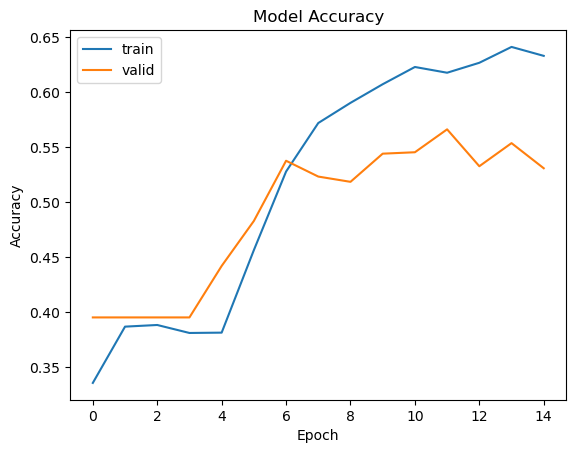

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

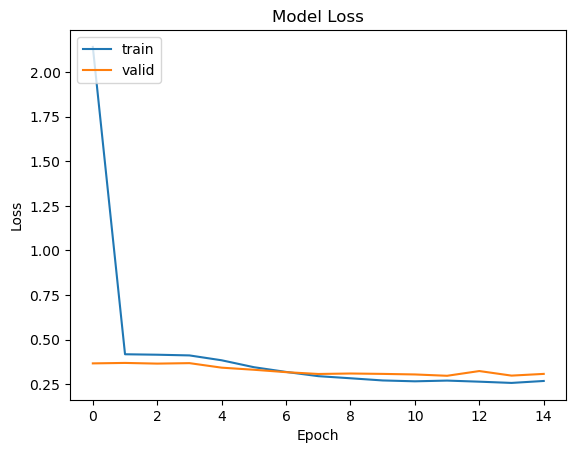

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

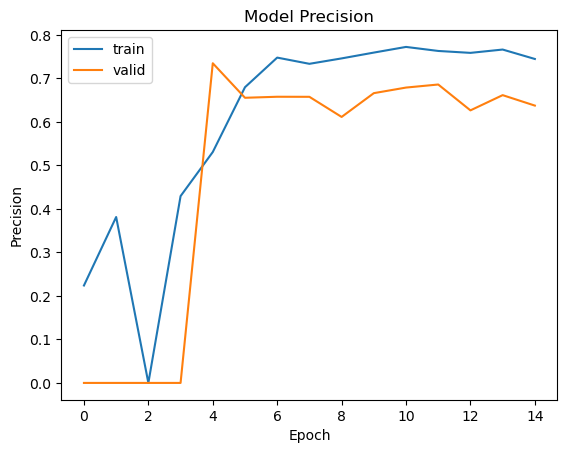

In [36]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Evaluating Model

Evaluating the model on Label Ranking Average Precision as it's a great metric to use for multi-label multi-class problems

In [37]:
pred_labels = model.predict(test_features)

170/170 [==============================] - 6s 7ms/step


In [38]:
model.evaluate(test_features, test_labels)

170/170 [==============================] - 1s 8ms/step - loss: 0.3105 - accuracy: 0.5353 - precision: 0.6392


[0.3104969561100006, 0.535286545753479, 0.6392356753349304]

In [39]:
pred_labels

array([[0.02594201, 0.00469747, 0.02051383, ..., 0.7777642 , 0.02922583,
        0.05891855],
       [0.27384964, 0.01373957, 0.00380145, ..., 0.04035587, 0.04720987,
        0.1156216 ],
       [0.02038045, 0.00078647, 0.00102755, ..., 0.03415214, 0.02880634,
        0.05743081],
       ...,
       [0.19436422, 0.00293911, 0.00337641, ..., 0.0219722 , 0.22490309,
        0.5613944 ],
       [0.05854265, 0.00365496, 0.00589835, ..., 0.05240134, 0.10822779,
        0.16585769],
       [0.07465524, 0.00311917, 0.01694682, ..., 0.08689094, 0.34205145,
        0.5028412 ]], dtype=float32)

In [40]:
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(test_labels, pred_labels)

0.723013971880752

In [41]:
def prob(x):
    if x>0.4:
        return 1
    return 0

pred_labels = [list(map(prob,i)) for i in pred_labels]

In [42]:
from sklearn.metrics import classification_report
target_names = train_data.columns[1:]
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.50      0.32      0.39       726
     disgust       0.00      0.00      0.00       123
        fear       0.00      0.00      0.00        98
         joy       0.84      0.58      0.69      2104
     sadness       0.44      0.44      0.44       379
    surprise       0.37      0.36      0.36       677
     neutral       0.51      0.69      0.58      1787

   micro avg       0.58      0.52      0.55      5894
   macro avg       0.38      0.34      0.35      5894
weighted avg       0.59      0.52      0.54      5894
 samples avg       0.54      0.54      0.53      5894



Well the Model doesn't seem to get any right for Class "disgust" or "fear"

# Testing With Stratified K-Fold Cross Validation

Just an experiment to see if anything improves or not

In [43]:
model_2 = create_model(max_seq_len, vocab_size, embedding_matrix_vocab)
model_2.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 33, 300)           6791700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 33, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [44]:
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, weight_decay=0.95),
              metrics=["accuracy"])

In [45]:
model_2.summary()

Model: "bilstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 33, 300)           6791700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 33, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
es_2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, label_ranking_average_precision_score

num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_accuracies = []
fold_precisions = []
fold_lraps = []

for fold, (train_index, val_index) in enumerate(skf.split(train_features, np.argmax(train_labels, axis=1)), 1):
    print(f'Fold {fold}:')
    
    # Split the data into training and validation sets for the current fold
    train_features_batch, valid_features_batch = train_features[train_index], train_features[val_index]
    train_labels_batch, valid_labels_batch = train_labels[train_index], train_labels[val_index]

    # Train the model for the current fold
    model.fit(train_features_batch, train_labels_batch, epochs=5, batch_size=1024, verbose=1, callbacks=[es_2])

    # Evaluate the model on the validation set for the current fold
    val_predictions = model.predict(valid_features_batch, verbose=0)
    val_labels_rounded = np.round(val_predictions)
    
    fold_accuracy = accuracy_score(valid_labels_batch, val_labels_rounded)
    fold_precision = precision_score(valid_labels_batch, val_labels_rounded, average='micro')
    fold_lrap = label_ranking_average_precision_score(valid_labels_batch, val_predictions)
    
    fold_accuracies.append(fold_accuracy)
    fold_precisions.append(fold_precision)
    fold_lraps.append(fold_lrap)

    print(f'Fold {fold} Validation Accuracy:', fold_accuracy)
    print(f'Fold {fold} Validation Precision:', fold_precision)
    print(f'Fold {fold} Validation LRAP:', fold_lrap)
    print()

Fold 1:
Epoch 1/5
34/34 [==============================] - 12s 343ms/step - loss: 0.2685 - accuracy: 0.6269 - precision: 0.7449
Epoch 2/5
34/34 [==============================] - 10s 305ms/step - loss: 0.2641 - accuracy: 0.6303 - precision: 0.7421
Epoch 3/5
34/34 [==============================] - 9s 268ms/step - loss: 0.2723 - accuracy: 0.6189 - precision: 0.7362
Epoch 4/5
34/34 [==============================] - 9s 278ms/step - loss: 0.2619 - accuracy: 0.6344 - precision: 0.7423
Epoch 5/5
34/34 [==============================] - 8s 225ms/step - loss: 0.2578 - accuracy: 0.6410 - precision: 0.7481
Fold 1 Validation Accuracy: 0.42605390463026954
Fold 1 Validation Precision: 0.7091925900034953
Fold 1 Validation LRAP: 0.7574456638986593

Fold 2:
Epoch 1/5
34/34 [==============================] - 9s 259ms/step - loss: 0.2666 - accuracy: 0.6232 - precision: 0.7332
Epoch 2/5
34/34 [==============================] - 9s 252ms/step - loss: 0.2596 - accuracy: 0.6359 - precision: 0.7432
Epoch 3/5

In [48]:
avg_accuracy = np.mean(fold_accuracies)
avg_precision = np.mean(fold_precisions)
avg_lrap = np.mean(fold_lraps)
print('Average Validation Accuracy:', avg_accuracy)
print('Average Validation Precision:', avg_precision)
print('Average Validation LRAP:', avg_lrap)

Average Validation Accuracy: 0.432780465330569
Average Validation Precision: 0.6959920625313636
Average Validation LRAP: 0.7547509351586641


In [49]:
pred_labels = model_2.predict(test_features)

170/170 [==============================] - 7s 8ms/step


In [50]:
label_ranking_average_precision_score(test_labels, pred_labels)

0.4481674519817137

In [51]:
pred_labels = [list(map(prob,i)) for i in pred_labels]

In [52]:
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

       anger       0.13      1.00      0.24       726
     disgust       0.02      1.00      0.04       123
        fear       0.02      1.00      0.04        98
         joy       0.39      1.00      0.56      2104
     sadness       0.07      1.00      0.13       379
    surprise       0.12      1.00      0.22       677
     neutral       0.33      1.00      0.50      1787

   micro avg       0.16      1.00      0.27      5894
   macro avg       0.16      1.00      0.25      5894
weighted avg       0.27      1.00      0.41      5894
 samples avg       0.16      1.00      0.27      5894



In [53]:
# As we can see the model predicts everything as 1 which makes the recall score above as 1 for every class
# This seems like an error
pred_labels[:5]

[[1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1]]